In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import xgboost as xgb

from pandas.plotting import scatter_matrix

import statsmodels.formula.api as smf

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 200

In [10]:
def load_lending_club(path_):
    date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d"]
    return pd.read_csv(path_, 
                 low_memory=False, 
                 parse_dates=date_cols, 
                 date_format="%b-%Y")

In [212]:
def tweak_lending_club(df_):
    drop_cols = ["debt_settlement_flag", "Unnamed: 0",  
                 "last_fico_range_low", "num_bc_sats", "num_bc_tl", 
                 "fico_range_low", "num_rev_accts", "out_prncp", 
                 "out_prncp_inv", "out_prncp_inv", "policy_code", 
                 "funded_amnt_inv", "loan_amnt", 
                 "collection_recovery_fee", "last_credit_pull_d", "id", 
                 "url", "pymnt_plan", "emp_title", 
                 "title", "zip_code", "verification_status", "last_pymnt_d"]
    high_nan_cols = ['all_util', 'annual_inc_joint', 'deferral_term', 
                     'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 
                     'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 
                     'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 
                     'hardship_status', 'hardship_type', 'il_util', 
                     'inq_fi', 'inq_last_12m', 'max_bal_bc', 
                     'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 
                     'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 
                     'next_pymnt_d', 'open_acc_6m', 'open_act_il', 
                     'open_il_12m', 'open_il_24m', 'open_rv_12m', 
                     'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 
                     'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 
                     'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 
                     'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_num_rev_accts', 
                     'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 
                     'total_bal_il', 'total_cu_tl', 'verification_status_joint']
    transformed_cols = ["term", "initial_list_status", 
                        "application_type", "hardship_flag", "emp_length", 
                        "int_rate", "revol_util"]
    object_cols = ["grade", "sub_grade", "home_ownership", 
                   "purpose", "addr_state", "issue_date_month"]
    return(pd.get_dummies(df_.assign(target = np.where((df_.loan_status == "Charged Off") | 
                                        (df_.loan_status == "Does not meet the credit policy. Status:Charged Off") | 
                                        (df_.loan_status == "Default"), 
                                        1, 0), 
                      term_36months = np.where(df_.term == "60 months", 0, 1), 
                      initial_list_status_w = np.where(df_.initial_list_status == "f", 0, 1), 
                      individual = np.where(df_.application_type == "Joint App", 0, 1),
                      hardhship = np.where(df_.hardship_flag == "Y", 1, 0),
                      employed_over_10yrs = np.where(df_.emp_length == "10+ years", 1, 0),
                      emp_years = df_.emp_length.map({"< 1 year": 0, "1 year": 1, "2 years": 2, 
                                                        "3 years": 3, "4 years": 4, "5 years": 5, 
                                                        "6 years": 6, "7 years": 7, "8 years": 8, 
                                                        "9 years": 9, "10+ years": 10}),
                      interest_rate = df_.int_rate.str.replace('%', '').astype(float),
                      revolving_util = df_.revol_util.str.replace('%', '').astype(float),
                      issue_date_month = df_.issue_d.dt.month.astype(str),
                      issue_date_year = df_.issue_d.dt.year,
                      years_since_earliest_cr_line = df_.issue_d.dt.year - df_.earliest_cr_line.dt.year,
                     ).drop(labels=drop_cols+high_nan_cols+transformed_cols, axis=1),
           columns=object_cols).fillna(method="ffill"))

In [ ]:
def quick_XGB(alg, X, y, X_t, y_t, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, cutoff=0.5):
    # create XGBoost models and perform cross-validation
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data=X, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    model_ = alg.fit(X, y)
        
    #Predict test set:
    dtrain_predictions = model_.predict(X_t)
    dtrain_predprob = model_.predict_proba(X_t)[:,1]
    #Print model report:
    df2_ = pd.DataFrame()
    df2_["churn_"] = y_t
    df2_["preds"] = np.where(dtrain_predprob>cutoff, 1, 0)
    
    
    print("Model Report")
    cm_ = metrics.confusion_matrix(y_t, df2_.preds)
    print(cm_)
    print(f"Adjusted accuracy: {((cm_[0][0]+cm_[1][1])/(cm_[0][0]+cm_[0][1]+cm_[1][0]+cm_[1][1])).round(3)}")
    print(f"Adjusted recall: {((cm_[1][1])/(cm_[1][0]+cm_[1][1])).round(3)}")
    print(f"Adjusted precision:{((cm_[1][1])/(cm_[0][1]+cm_[1][1])).round(3)}")
    print("Raw Accuracy : %.4g" % metrics.accuracy_score(y_t, dtrain_predictions))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(y_t, dtrain_predprob))
                   
    feat_imp = pd.Series(model_.get_booster().get_score(importance_type='weight')).nlargest(10).sort_values()
    print(feat_imp)
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    
    # Accuracy vs Recall Graph
    cutoff_ = []
    recall_ = []
    accuracy_ = []
    
    benefit_ = []
    
    for co_ in np.arange(0.1, .99, 0.01):
        cutoff_.append(co_)
        preds_g = np.where(dtrain_predprob>co_, 1, 0)
        cm_ = metrics.confusion_matrix(y_t, preds_g)
        recall_.append(((cm_[1][1])/(cm_[1][0]+cm_[1][1])).round(3))
        accuracy_.append(((cm_[0][0]+cm_[1][1])/(cm_[0][0]+cm_[0][1]+cm_[1][0]+cm_[1][1])).round(3))
        # Select values for correctly predicting fraud and incorrectly identifying a transaction as fraudulent.
        benefit_.append(600*cm_[1][1] - 50*cm_[0][1])
    r_a_tradeoff = [0] + [100*((recall_[i]-recall_[i-1]) + accuracy_[i]-accuracy_[i-1]) for i in range(1, len(recall_))]
    df_graph = pd.DataFrame(list(zip(cutoff_, recall_, accuracy_, benefit_, r_a_tradeoff)), 
                            columns=["cutoff", "recall", "accuracy", "benefit", "tradeoff"])
    
    df_graph["ar"] = (df_graph.recall + df_graph.accuracy)/2
    
    print(f"Max Accuracy cutoff: {(df_graph.sort_values(by='accuracy', ascending=False).cutoff.iloc[0]).round(2)}")
    print(f"Max benefit cutoff: {(df_graph.sort_values(by='benefit', ascending=False).cutoff.iloc[0]).round(2)}")
    plt.scatter(x="cutoff", y="recall", data=df_graph, s=4, label="Proportion of Fraudulent Transaction Correctly Identified")
    plt.scatter(x="cutoff", y="accuracy", data=df_graph, s=4, c="red", label="Proportion of Correctly Classified Transactions")
    plt.scatter(x="cutoff", y="ar", data=df_graph, s=4, c="black", label="Cumulative Tradeoff")
    plt.xlabel("Cutoff Percentage")
    plt.legend()
    plt.ylim(-1, 1)
    plt.show()
    
    plt.scatter(x="cutoff", y="benefit", data=df_graph, s=4, c="red")
    plt.title("Benefit Curve by Cutoff Point")
    plt.show()
    
    return model_
    
    

In [213]:
df = tweak_lending_club(load_lending_club("lending_club_sample.csv"))
print(df.shape)

(300000, 194)


In [219]:
# for item in df.columns:
#     print(item)

In [68]:
def biased_sample(df_):
    """
    Heavily samples from low-employment experience w/o default.
    Returns feature matrix and target vector.
    """
    biased_df = df_.sort_values(by = ["target", "emp_years"]).loc[:20000, :].sample(20000, replace=True)
    
    biased_df = pd.concat([df.sample(40000), biased_df])
    return biased_df.drop(labels="target", axis=1), biased_df["target"]

In [230]:
X_bias, y_bias = biased_sample(df)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels="target", axis=1), 
                                                    df["target"], 
                                                    test_size=0.2, 
                                                    random_state=2112)

In [208]:
# The last item of each categorical dummy set and the datetime series.
logit_drop_cols = ["grade_G", "sub_grade_G5", "home_ownership_NONE", 
                   "purpose_other", "addr_state_WY", "issue_date_month_12"] + list(df.select_dtypes(include='datetime').columns)

logit_drop_cols_grade = ["grade_A", "grade_B", "grade_C", 
                         "grade_D", "grade_E","grade_F"]

logit_drop_cols_subgrade = ["sub_grade_A1", "sub_grade_A2", "sub_grade_A3", 
                             "sub_grade_A4", "sub_grade_A5", "sub_grade_B1", 
                             "sub_grade_B2", "sub_grade_B3", "sub_grade_B4", 
                             "sub_grade_B5", "sub_grade_C1", "sub_grade_C2", 
                             "sub_grade_C3", "sub_grade_C4", "sub_grade_C5", 
                             "sub_grade_D1", "sub_grade_D2", "sub_grade_D3", 
                             "sub_grade_D4", "sub_grade_D5", "sub_grade_E1", 
                             "sub_grade_E2", "sub_grade_E3", "sub_grade_E4", 
                             "sub_grade_E5", "sub_grade_F1", "sub_grade_F2", 
                             "sub_grade_F3", "sub_grade_F4", "sub_grade_F5", 
                             "sub_grade_G1", "sub_grade_G2", "sub_grade_G3", 
                             "sub_grade_G4"]

logit_state_dummies = ["addr_state_AK", "addr_state_AL", "addr_state_AR", 
                 "addr_state_AZ", "addr_state_CA", "addr_state_CO", 
                 "addr_state_CT", "addr_state_DC", "addr_state_DE", 
                 "addr_state_FL", "addr_state_GA", "addr_state_HI", 
                 "addr_state_ID", "addr_state_IL", "addr_state_IN", 
                 "addr_state_KS", "addr_state_KY", "addr_state_LA", 
                 "addr_state_MA", "addr_state_MD", "addr_state_ME", 
                 "addr_state_MI", "addr_state_MN", "addr_state_MO", 
                 "addr_state_MS", "addr_state_MT", "addr_state_NC", 
                 "addr_state_ND", "addr_state_NE", "addr_state_NH", 
                 "addr_state_NJ", "addr_state_NM", "addr_state_NV", 
                 "addr_state_NY", "addr_state_OH", "addr_state_OK", 
                 "addr_state_OR", "addr_state_PA", "addr_state_RI", 
                 "addr_state_SC", "addr_state_SD", "addr_state_TN", 
                 "addr_state_TX", "addr_state_UT", "addr_state_VA", 
                 "addr_state_VT", "addr_state_WA", "addr_state_WI", 
                 "addr_state_WV"]

logit_issue_date_month_dummies = ["issue_date_month_1", "issue_date_month_10", "issue_date_month_11", 
                            "issue_date_month_2", "issue_date_month_3", 
                            "issue_date_month_4", "issue_date_month_5", "issue_date_month_6", 
                            "issue_date_month_7", "issue_date_month_8", "issue_date_month_9"] 

logit_drop_all = logit_drop_cols + logit_drop_cols_subgrade + logit_state_dummies + logit_issue_date_month_dummies




In [127]:
X = X_train.drop(labels = logit_drop_cols+logit_drop_cols_subgrade, axis=1)

categorical_features = list(df.nunique().loc[df.nunique()==2].index)
date_features = list(df.select_dtypes(include='datetime').columns)
numeric_features = list(df.columns)

for i in (categorical_features + date_features):
    numeric_features.remove(i)


numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessor = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_features),
        ("cat",
            SimpleImputer(strategy="median"),
            categorical_features,
        ),
    ],
    verbose_feature_names_out=False,
)
log_reg = make_pipeline(preprocessor, SelectKBest(k=20), LogisticRegression())


In [140]:
imp = SimpleImputer(strategy="median")
logl_X_train = X_train.drop(labels = logit_drop_cols+logit_drop_cols_subgrade, axis=1).iloc[:, :10]
imp.fit(logl_X_train)
logl_X_train = imp.transform(logl_X_train)
logl_X_train[:5, :]

array([[1.4000e+03, 4.3550e+01, 4.2200e+04, 1.2260e+01, 0.0000e+00,
        6.8400e+02, 0.0000e+00, 4.0000e+00, 0.0000e+00, 2.6310e+03],
       [5.0000e+03, 1.8074e+02, 4.0000e+04, 8.8400e+00, 0.0000e+00,
        7.2900e+02, 0.0000e+00, 4.0000e+00, 0.0000e+00, 2.7920e+03],
       [7.2000e+03, 2.2526e+02, 2.2000e+04, 2.5930e+01, 0.0000e+00,
        7.3900e+02, 0.0000e+00, 9.0000e+00, 0.0000e+00, 3.4310e+03],
       [1.0000e+04, 3.1374e+02, 2.6376e+04, 1.8740e+01, 0.0000e+00,
        7.0400e+02, 0.0000e+00, 5.0000e+00, 0.0000e+00, 1.4575e+04],
       [1.9200e+04, 4.3431e+02, 8.1000e+04, 2.5900e+01, 0.0000e+00,
        6.8900e+02, 2.0000e+00, 1.2000e+01, 0.0000e+00, 1.4916e+04]])

In [141]:
clf = LogisticRegression(max_iter=2000)

clf.fit(logl_X_train, y_train)


LogisticRegression(max_iter=2000)

In [163]:
for i, j in zip(clf.coef_.tolist()[0], list(X_train.drop(labels = logit_drop_cols+logit_drop_cols_subgrade, axis=1).iloc[:, :10].columns)):
    print(f"{j}:  {i}\n")

funded_amnt:  3.1856444490646005e-06

installment:  0.0007260325829592549

annual_inc:  -4.571297852138133e-06

dti:  1.5607961777220163e-05

delinq_2yrs:  6.8005579264641815e-06

fico_range_high:  -0.0027576657751706437

inq_last_6mths:  2.7911428062630048e-05

open_acc:  3.4841431393626774e-05

pub_rec:  7.322197322802492e-06

revol_bal:  -3.7331899633959386e-06



In [201]:
def smf_logit(df_, y_, logit_cols_=None, logit_drop_=None):
    if logit_drop_:
        sm_df = df_.drop(labels=logit_drop_, axis=1).dropna()
    elif logit_cols_:
        sm_df = df_.loc[:, logit_cols_+[y_]].copy().dropna()   
    else:
        sm_df = df_.copy().dropna()
        
    formula = y_ + " ~ "
    for column in sm_df.drop(labels=[y_], axis=1).columns:
        formula += column + " + "
    formula = formula[:-3]
    
    print(f"{formula}")
    sm_model = smf.logit(formula, data=sm_df).fit()
    print(sm_model.summary())

In [ ]:
smf_logit(df, "target", logit_drop_=logit_drop_all)

In [182]:
df.columns[:4]

Index(['funded_amnt', 'installment', 'annual_inc', 'issue_d'], dtype='object')

In [207]:
temp = ""
for col in list(df.columns):
    temp += ('\", \"' + col)
print(temp)

", "funded_amnt", "installment", "annual_inc", "issue_d", "loan_status", "dti", "delinq_2yrs", "earliest_cr_line", "fico_range_high", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "total_acc", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "last_pymnt_amnt", "last_fico_range_high", "collections_12_mths_ex_med", "acc_now_delinq", "tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy", "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc", "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl", "num_actv_rev_tl", "num_il_tl", "num_op_rev_tl", "num_rev_tl_bal_gt_0", "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m", "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies", "tax_liens", "tot_hi_

In [211]:
df.drop(labels=logit_drop_all, axis=1).dropna().describe()

,funded_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_il_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,target,term_36months,initial_list_status_w,individual,hardhship,employed_over_10yrs,emp_years,interest_rate,revolving_util,issue_date_year,years_since_earliest_cr_line
count,226377.000000,226377.000000,2.263770e+05,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,2.263770e+05,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,2.263770e+05,2.263770e+05,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,2.263770e+05,2.263770e+05,226377.000000,2.263770e+05,226377.000000,226377.0,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000,226377.000000
mean,15690.944641,461.506789,8.406246e+04,19.481153,0.295361,703.926927,0.596346,12.273875,0.182567,1.704980e+04,25.189785,12793.997201,12789.583960,10086.211416,2528.480526,1.794527,177.510694,3664.612886,689.408085,0.016910,0.003331,224.875213,1.566105e+05,3.712311e+04,4.882802,14205.097651,13197.729389,55.078061,0.008022,11.277599,125.897375,174.701697,13.095407,7.175831,1.580408,23.435884,7.113572,0.529572,3.756813,5.656922,9.218406,8.541495,5.673302,12.250348,0.000548,0.002178,0.073135,2.241513,94.365072,38.931450,0.127023,0.037844,1.959651e+05,5.701655e+04,25349.890735,5.005996e+04,0.123763,1.0,0.746370,0.930050,0.044753,0.349965,5.852145,13.153252,48.098954,2016.744731,16.081965
std,9498.225522,273.383282,8.258127e+04,12.425889,0.842933,33.146038,0.851906,5.807795,0.527220,2.266262e+04,12.194136,10462.893534,10459.474787,8788.585088,2801.366119,14.443542,865.606545,6312.072837,74.134892,0.144874,0.064421,1863.985128,1.680356e+05,3.597125e+04,3.166308,16365.055606,18329.393158,28.610300,0.100478,658.089827,54.181899,92.837037,16.039780,6.810951,1.892902,30.448288,5.956372,1.420762,2.333540,3.333672,7.601963,4.820949,3.340905,5.805009,0.028505,0.049198,0.454241,1.858323,8.760065,35.574722,0.362568,0.324455,1.894522e+05,5.376695e+04,24600.455570,4.801438e+04,0.329311,0.0,0.435089,0.255063,0.206761,0.476960,3.746151,4.886858,24.398892,1.966689,7.321100
min,1000.000000,30.120000,2.000000e+01,0.000000,0.000000,664.000000,0.000000,1.000000,0.000000,0.000000e+00,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1072.080000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.700000,0.000000,0.000000,0.000000,3.000000e+02,0.000000e+00,200.000000,0.000000e+00,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.310000,0.000000,2012.000000,3.000000
25%,8350.0000

# XGBoost

In [220]:
XG_drop_cols = ["loan_status"]+list(df.select_dtypes(include='datetime').columns)

In [223]:
y = df["target"].copy()
X = df.drop(["target"]+XG_drop_cols, axis=1)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=43)

In [224]:
xg = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=4,
 min_child_weight=1,
 gamma=1, reg_lambda=2,
 subsample=0.6,
 colsample_bytree=0.4,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 eval_metric='aucpr',
 seed=2112)

In [234]:
X_XG_bias = X_bias.drop(XG_drop_cols, axis=1)

Model Report
[[52399    93]
 [  888  6620]]
Adjusted accuracy: 0.984
Adjusted recall: 0.882
Adjusted precision:0.986
Raw Accuracy : 0.9837
AUC Score (Test): 0.995712
total_rec_late_fee      17.0
total_pymnt             22.0
recoveries              22.0
total_pymnt_inv         34.0
installment             36.0
issue_date_year         37.0
funded_amnt             57.0
total_rec_prncp         74.0
last_pymnt_amnt         81.0
last_fico_range_high    82.0
dtype: float64


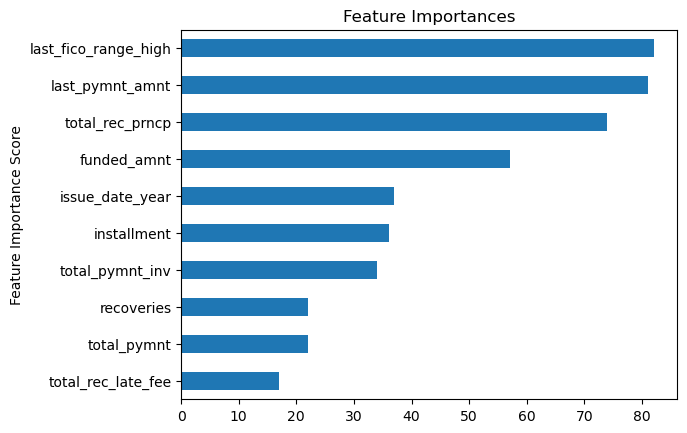

Max Accuracy cutoff: 0.34
Max benefit cutoff: 0.1


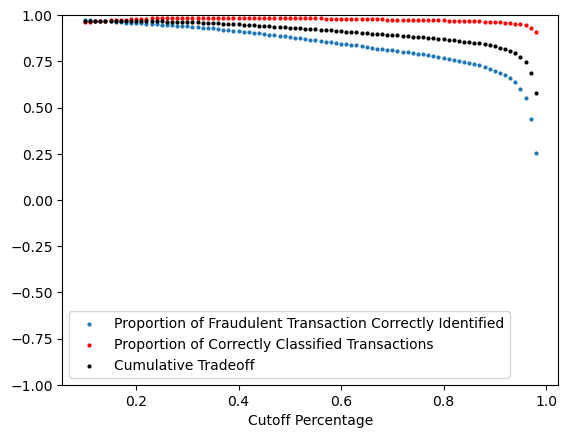

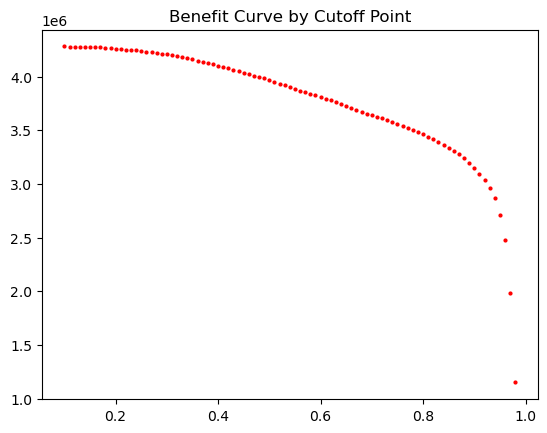

In [238]:
quick_XGB(xg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, cutoff=0.5)

In [243]:
use_cols = ["last_fico_range_high", "last_pymnt_amnt", "total_rec_prncp", 
            "funded_amnt", "issue_date_year", "installment", 
            "total_pymnt_inv", "total_pymnt"]
smf_logit(df, "target", logit_cols_=use_cols)

target ~ last_fico_range_high + last_pymnt_amnt + total_rec_prncp + funded_amnt + issue_date_year + installment + total_pymnt_inv + total_pymnt
Optimization terminated successfully.
         Current function value: 0.110045
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               300000
Model:                          Logit   Df Residuals:                   299991
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Aug 2023   Pseudo R-squ.:                  0.7081
Time:                        14:17:36   Log-Likelihood:                -33013.
converged:                       True   LL-Null:                   -1.1310e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [242]:
df.loc[:, use_cols].head()

,last_fico_range_high,last_pymnt_amnt,total_rec_prncp,funded_amnt,issue_date_year,installment,total_pymnt_inv,recoveries,total_pymnt
0,534.0,830.99,2746.05,32075.0,2019,830.99,6614.17,0.0,6614.170000
1,759.0,840.11,4189.85,27200.0,2019,840.11,5030.05,0.0,5030.050000
2,684.0,461.13,8988.45,20000.0,2017,461.13,14801.46,0.0,14801.460000
3,714.0,6770.52,9600.00,9600.0,2016,307.48,10455.22,0.0,10455.217527
4,689.0,9166.10,16000.00,16000.0,2013,404.30,22309.30,0.0,22309.300000
